A.S. Lundervold, v051022

# Introduction

This notebook builds on `DAT158-2.1-LinReg_GradientDescent.ipynb` and `DAT158-2.2-PolyReg_learning_curves_bias-variance.ipynb` and introduces the concept of **regularization**. 

> Regularization: Improving models by constraining them.

See also Geron's notebook here: https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb

**This notebook will repeat some of what we covered in Part 1, in the notebook `DAT158-1.2-extra-Intro_to_ML.ipynb`.** So it would be best if you studied both of them.

# Setup

We set up our standard environment below.

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Introduction

Remember the bias-variance tradeoff:

<img src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/biasvariance_combined.png"><br><small><center>Images from http://scott.fortmann-roe.com/docs/BiasVariance.html</center></small>

High bias models are typically too simple and tend to underfit, while high variance models are too tuned to the training data and tend to overfit. The best models are the ones that are *just* perfect: not too simple, not too complex, with both low bias and low variance.

> How do we turn something that overfits into something that generalizes well to new data? In other words, how do we reduce the variance of a model? 

<center>An answer is <b>regularization</b> (at least sometimes).</center>

Regularization refers to any technique that increases generalization without sacrificing training set performance. Here we'll discuss some widely used regularization methods based on constraining a model's parameters. 

>How do you reduce model variance? Idea: Since many degrees of freedom causes overfitting, we constrain the model to make it use fewer large parameters. 

# Regularization for linear models

We'll look at the following methods:

1. Tikhonov regularization / ridge regression
2. Lasso regression
3. Elastic net
4. Early stopping

We need some data to experiment with:

In [5]:
np.random.seed(seed)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

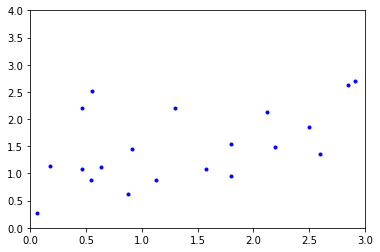

In [6]:
plt.plot(X,y, 'b.')
plt.axis([0, 3, 0, 4])
plt.show()

Remember the mean squared error cost function we used for regression:

$$\mbox{MSE}(\theta) = \frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x}^{(i)} - y^{(i)} \big)^2$$

Training a model means tweaking the parameters $\theta$ to make $\mbox{MSE}(\theta)$ as small as possible. 

Here's a linear regression model for the above data obtained by minimizing MSE:

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

X_new = np.array([[0], [4]])
y_pred = lin_reg.predict(X_new)

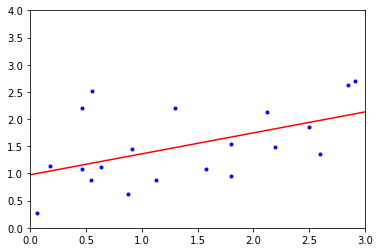

In [8]:
plt.plot(X,y, 'b.')
plt.plot(X_new, y_pred, 'r')
plt.axis([0, 3, 0, 4])
plt.show()

Let's create a function that performs polynomial regression (copied from the previous notebook):

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [10]:
def get_polyreg(degree):
    poly_reg = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                            StandardScaler(), 
                             LinearRegression())
    
    return poly_reg

In [11]:
def plot_poly_regression(degree):
    poly_reg = get_polyreg(degree)
    poly_reg.fit(X, y)
    X_new = np.linspace(0, 4, 100).reshape(100, 1)
    y_pred = poly_reg.predict(X_new)
    plt.plot(X,y, 'b.')
    plt.plot(X_new, y_pred, 'r-')
    plt.axis([0, 3, 0, 4])
    plt.show()
    return poly_reg

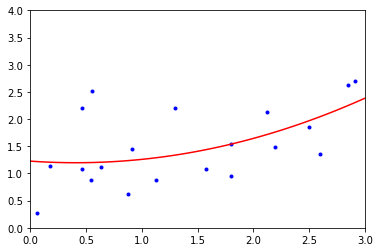

In [12]:
poly_reg_2 = plot_poly_regression(2)

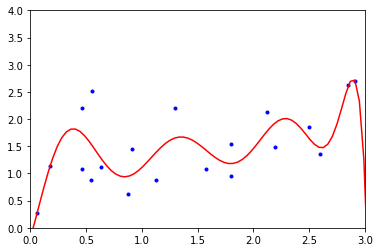

In [13]:
poly_reg_10 = plot_poly_regression(10)

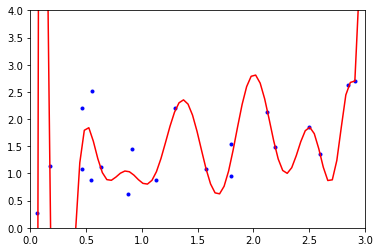

In [14]:
poly_reg_15 = plot_poly_regression(15)

Notice how the degree 15 polynomial is severely overfitting the training data. This is reflected in the size of the coefficients in the polynomial:

In [15]:
poly_reg_15.named_steps['linearregression'].coef_

array([[ 4.42501254e+03, -1.56338419e+05,  2.60314103e+06,
        -2.59913452e+07,  1.71878704e+08, -7.93930819e+08,
         2.64228282e+09, -6.44671257e+09,  1.16115731e+10,
        -1.53996877e+10,  1.48372274e+10, -1.00926940e+10,
         4.59152094e+09, -1.25291615e+09,  1.54998397e+08]])

**They are huge!**

Here's an idea: what if we incentivize the model to prefer smaller coefficients? Perhaps that would help?

## Ridge regression

> A technique for making the coefficients smaller (_shrinkage_)

We can do that by changing the cost function (MSE) by adding a term that tracks the coefficient sizes:

$$\frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x} - y^{(i)} \big)^2 + \alpha \frac12 \sum_1^m \theta_i^2$$

Notice that since the model is trying to minimize the cost function, this forces the model to try to keep the weights as small as possible. 

This is called **Tikhonov regularization** or **ridge regression**. The above regularization term (or *penalty term*) is also called an $l_2$ penalty (for mathematical reasons: it corresponds to the so-called $l_2$ norm of the weight vector).

The hyperparameter $\alpha$ controls how much regularization to use (in other words, the amount of shrinkage). If we set it to zero, we recover the standard MSE. If we make it very large, all the weights will tend to shrink to zero.

By shrinking the coefficients, ridge regression can help alleviate the problem of correlated features having huge coefficients that cancel each other out. I.e., where a large positive coefficient in front of one feature can be canceled by a large negative coefficient in front of another, leading to high variance. 

## Ridge regression in scikit-learn

We can use the `Ridge` model to perform ridge regression:

In [16]:
from sklearn.linear_model import Ridge

In [17]:
def get_ridgereg(degree, alpha):
    ridge_reg = make_pipeline(PolynomialFeatures(degree=degree),
                              StandardScaler(), 
                              Ridge(alpha=alpha))
    
    return ridge_reg

In [18]:
def plot_ridge_reg(degree, alpha):
    ridge_reg = get_ridgereg(degree, alpha)
    ridge_reg.fit(X, y)
    X_new = np.linspace(0, 4, 100).reshape(100, 1)
    y_pred = ridge_reg.predict(X_new)
    plt.plot(X,y, 'b.')
    plt.plot(X_new, y_pred, 'r-')
    plt.axis([0, 3, 0, 4])
    plt.show()
    return ridge_reg

Here's the polynomial regression we had earlier:

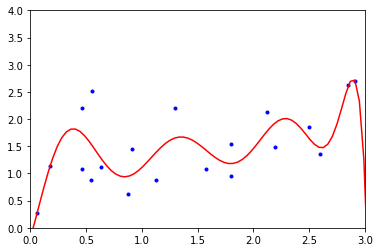

In [19]:
_ = plot_poly_regression(degree=10)

As expected, it's the same as setting the alpha parameter to zero in the Ridge regression:

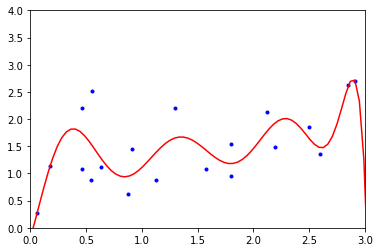

In [20]:
_ = plot_ridge_reg(degree=10,alpha=0)

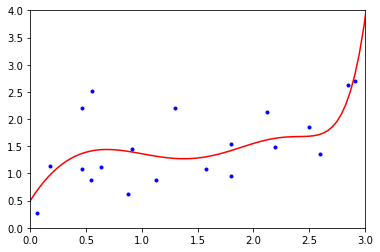

In [21]:
_ = plot_ridge_reg(10, 0.001)

...and play around with various combinations of degrees and amount of regularization:

In [22]:
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [23]:
interactive_plot = interactive(plot_ridge_reg, 
                               degree = IntSlider(min=1, max=50, step=1, value=15), 
                               alpha=FloatSlider(min=0., max=0.1, step=1e-6, value=0))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=15, description='degree', max=50, min=1), FloatSlider(value=0.0, descrip…

We notice that the more complex model (i.e., higher degree), the more regularization is needed to make it reasonable.

> **Note**: We can add Tikhonov regularization / l2-penalty also to other cost functions and training algorithms, including gradient descent. In the context of artificial neural networks, this is called _weight decay_.

As alpha, the amount of shrinkage, is a hyperparameter of the model, one should select it based on cross-validation or by creating a separate validation data set. 

> **Your turn!** Make a training, validation, and test set by generating some new data points. Train models with different alpha values and test them on the validation set. Once you find a value that seems promising, try it on the test set. You may consider using `GridSearchCV`. 

**A solution:**

In [24]:
#%load https://github.com/alu042/DAT158-2022/raw/main/notebooks/solutions/2.3-regularization-1.py

## Lasso regression

> A technique for shrinking the coefficients to zero

Lasso regression (_Least Absolute Shrinkage and Selection Operator Regression_) is based on the same idea as ridge regression, but uses the $l_1$-norm instead of the $l_2$ norm:

$$\frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x} - y^{(i)} \big)^2 + \alpha \sum_1^m |\theta_i|$$

We can repeat the above experiments for Lasso, by just replacing "Ridge" with "Lasso" everywhere in the above code:

In [25]:
from sklearn.linear_model import Lasso

In [26]:
def get_lassoreg(degree, alpha):
    lasso_reg = make_pipeline(PolynomialFeatures(degree=degree),
                              StandardScaler(), 
                              Lasso(alpha=alpha))
    
    return lasso_reg

In [27]:
def plot_lasso_reg(degree, alpha):
    lasso_reg = get_lassoreg(degree, alpha)
    lasso_reg.fit(X, y)
    X_new = np.linspace(0, 4, 100).reshape(100, 1)
    y_pred = lasso_reg.predict(X_new)
    plt.plot(X,y, 'b.')
    plt.plot(X_new, y_pred, 'r-')
    plt.axis([0, 3, 0, 4])
    plt.show()
    return lasso_reg

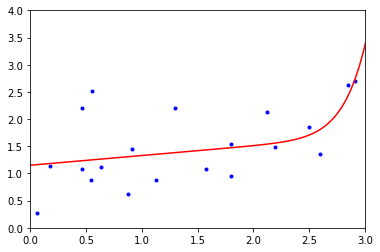

In [28]:
_ = plot_lasso_reg(15, 0.01)

...and play around with various combinations of degrees and amount of regularization:

In [29]:
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [30]:
interactive_plot = interactive(plot_lasso_reg, 
                               degree = IntSlider(min=20, max=50, step=1, value=30), 
                               alpha=FloatSlider(min=0., max=0.1, step=1e-6, value=0.01))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=30, description='degree', max=50, min=20), FloatSlider(value=0.01, descr…

In ridge regression, the higher-valued $\theta_i$ automatically get more penalized than they do in lasso regression since the $\theta_i$'s are squared in the cost function. 

This leads to lasso regression being more aggressive in eliminating weights altogether by setting them to zero. This is a form of **feature selection** (a continuous feature selection): Lasso tends to remove unimportant features from the model automatically.

## Elastic net

> A tradeoff between shrinking the coefficients to zero and making them small

This is simply a weighted average of ridge regression and lasso regression, with a hyperparameter $r$ that controls the mix ratio:

$$\frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x} - y^{(i)} \big)^2 + r\cdot \alpha \sum_1^m |\theta_i| + \frac{1-r}{2} \cdot \alpha  \sum_1^m \theta_i^2$$

When $r=0$ elastic net is equal to ridge regression. When $r=1$ it's equal to lasso regression. 

It's available through scikit-learn

In [31]:
from sklearn.linear_model import ElasticNet

and you can use it in a similar way as above.

In [32]:
#?ElasticNet

## Summary so far

> **When should you use linear regression, ridge, lasso or elastic net?**

* Plain linear regression is not in general a good idea. Always include some regularization.
* Use ridge unless you want the feature selection aspect of lasso (you suspect that only a few features are useful). But in that case, use elastic net with $r > 0$, not pure lasso.

## Early stopping

The idea of early stopping is simple: monitor the validation error during training, and stop the training once the validation performance error reaches a minimum (i.e., before it starts increasing). 

Early stopping is a different kind of regularization than ridge, lasso, and elastic net: instead of constraining the weights directly by modifying the cost function, you constrain the possible weight combinations by stopping the training early (i.e., restricting the reachable parameter space).

<img src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/early_stopping.png">

Here's an implementation for the `SGDRegressor`:

In [33]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Make some training and validation data, add lots of polynomial features, and scale it:

In [34]:
np.random.seed(42)
m_more = 100
X_more = 6 * np.random.rand(m_more, 1) - 3
y_more = 2 + X_more + 0.5 * X_more**2 + np.random.randn(m_more, 1)

X_train, X_val, y_train, y_val = train_test_split(X_more[:50], y_more[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = make_pipeline(
        PolynomialFeatures(degree=90, include_bias=False),
        StandardScaler())

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

Train models keeping track of the validation error. Save the model with the lowest validation error:

In [35]:
from copy import deepcopy

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, 
                       learning_rate="constant", eta0=0.0005, random_state=10)
# 'Warm start' makes the training start where it left off

minimum_val_error = float("inf")
best_epoch=None
best_model=None
for epoch in range(1001):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [36]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=10, tol=-inf, warm_start=True))

Predict with the best model:

In [37]:
y_val_predict_best = best_model.predict(X_val_poly_scaled)

In [38]:
mean_squared_error(y_val_predict_best, y_val)

1.3192567103102852

In [39]:
minimum_val_error

1.3192567103102852

**What if we had just trained a model for 1000 epochs without early stopping?**

> **Your turn!** Train the `SGDRegressor` model for 1000 epochs and check the mean squared error of the final model. Make sure that you use `learning_rate="constant"`, `eta0=0.0005` and `random_state=10` to directly compare with the above result.

**A solution**

In [40]:
# %load https://github.com/alu042/DAT158-2022/raw/main/notebooks/solutions/2.3-early_stopping.py